In [33]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Sin sampleo

In [35]:
train.set_index('id')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1


In [36]:
test_id = test['id']

In [37]:
X = train.drop(['loan_status'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

vars_cat = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
    ('cat', categorical_transformer, vars_cat)
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [38]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     15126
           1       0.77      0.54      0.63      2468

    accuracy                           0.91     17594
   macro avg       0.85      0.76      0.79     17594
weighted avg       0.91      0.91      0.91     17594

0.9126975105149483


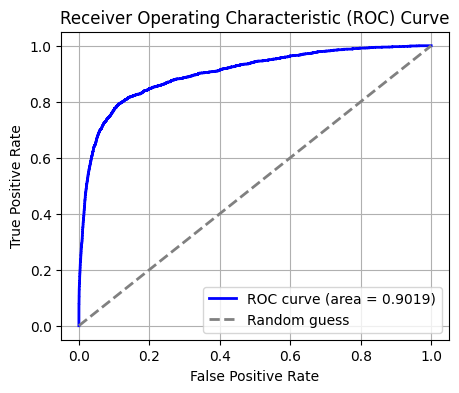

In [39]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<Figure size 500x400 with 0 Axes>

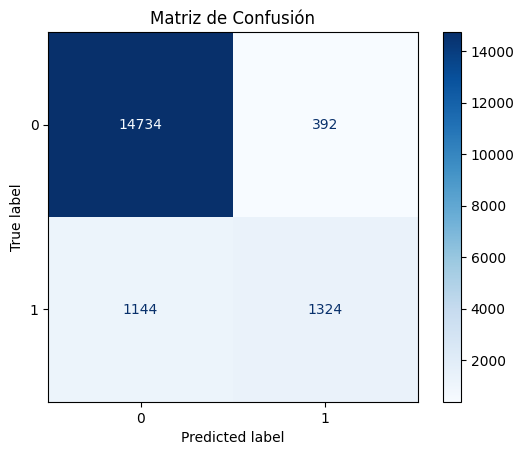

In [40]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

In [41]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score_og = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_og)

Accuracy: 0.9126975105149483
Precision: 0.9060131626315379
Recall: 0.9126975105149483
F1 Score: 0.9059107294041481


## Undersampling

In [42]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 35169, 1: 5882})
Resample dataset shape Counter({0: 5882, 1: 5882})


In [43]:
model.fit(x_rus, y_rus)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     15126
           1       0.46      0.83      0.59      2468

    accuracy                           0.84     17594
   macro avg       0.71      0.83      0.75     17594
weighted avg       0.90      0.84      0.86     17594

0.8390928725701944


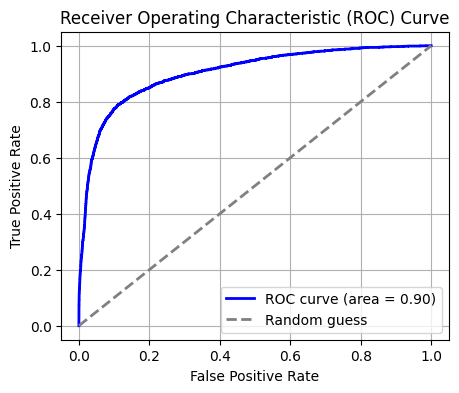

In [44]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

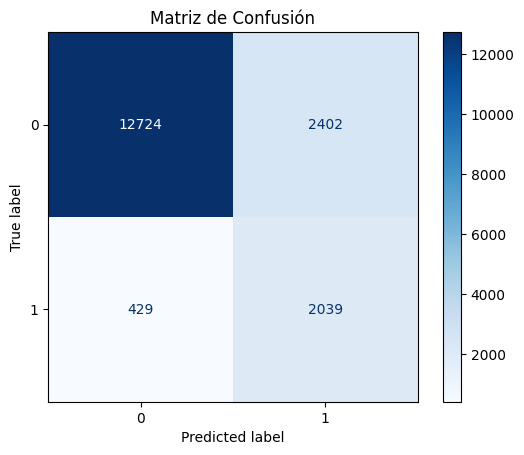

In [45]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# Random Over Sampling

In [46]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler()
x_ros, y_ros = smote.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

original dataset shape: Counter({0: 35169, 1: 5882})
Resample dataset shape Counter({0: 35169, 1: 35169})


In [47]:
model.fit(x_ros, y_ros)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     15126
           1       0.46      0.82      0.59      2468

    accuracy                           0.84     17594
   macro avg       0.71      0.83      0.75     17594
weighted avg       0.90      0.84      0.86     17594

0.8402864612936228


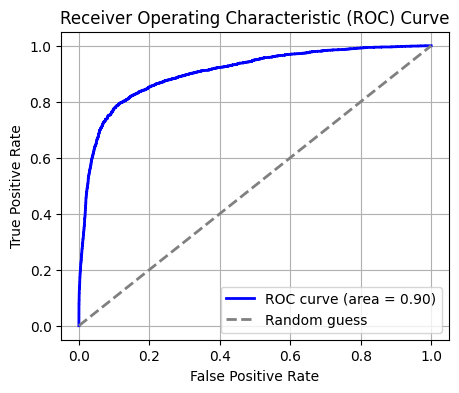

In [48]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

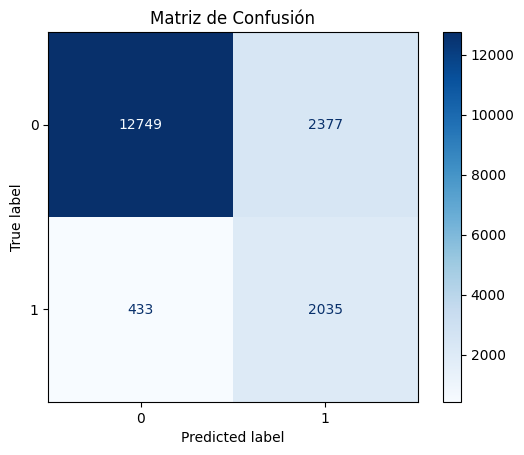

In [49]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# SMOTE

In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 35169, 1: 5882})
Resample dataset shape Counter({0: 35169, 1: 35169})


In [51]:
model.fit(x_smote, y_smote)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90     15126
           1       0.47      0.82      0.60      2468

    accuracy                           0.84     17594
   macro avg       0.72      0.84      0.75     17594
weighted avg       0.90      0.84      0.86     17594

0.8449471410708196


<Figure size 500x400 with 0 Axes>

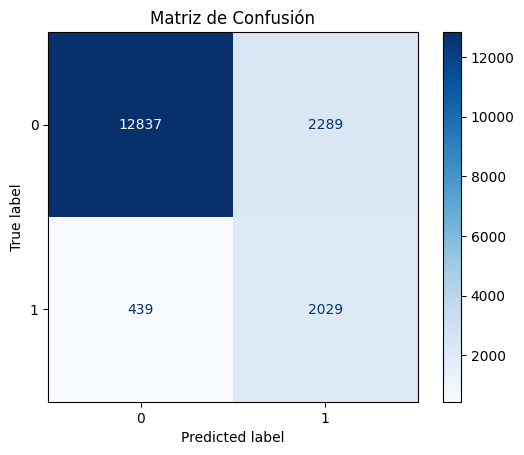

In [52]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

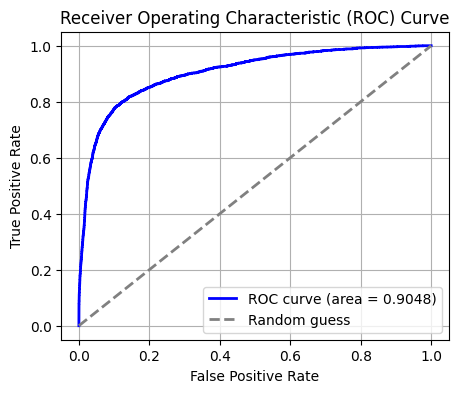

In [53]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [64]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1_score_smote = f1_score(y_val, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_smote)

Accuracy: 0.8449471410708196
Precision: 0.4698934691987031
Recall: 0.8221231766612642
F1 Score: 0.5979958738579428


# Comparativa

In [55]:
model.fit(X_train, y_train)
predict_y = model.predict(X_val)
print('F1 score DF Original:',round(f1_score(y_val, predict_y),2))

model.fit(x_rus, y_rus)
predict_y = model.predict(X_val)
print('F1 score Under-sampling:',round(f1_score(y_val, predict_y),2))

model.fit(x_ros, y_ros)
predict_y = model.predict(X_val)
print('F1 score Over-sampling:',round(f1_score(y_val, predict_y),2))

model.fit(x_smote, y_smote)
predict_y = model.predict(X_val)
print('F1 score SMOTE:',round(f1_score(y_val, predict_y),2))

F1 score DF Original: 0.63
F1 score Under-sampling: 0.59
F1 score Over-sampling: 0.59
F1 score SMOTE: 0.6


### Guardar resultados de test para subir a kaggle

In [56]:
# Transformaciones
test = preprocessor.fit_transform(test)

In [57]:
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(test)[:, 1]

In [58]:
y_pred_prob

array([0.93394323, 0.01013705, 0.57187536, ..., 0.04502003, 0.93239908,
       0.7752987 ])

In [59]:
predictions = pd.DataFrame(y_pred_prob)

In [60]:
predictions = predictions.reset_index().rename(columns={
    'index':'id',
    0:'loan_status'
})

In [61]:
predictions['id'] = test_id

In [62]:
predictions.head()

,id,loan_status
0,58645,0.933943
1,58646,0.010137
2,58647,0.571875
3,58648,0.098452
4,58649,0.385042


In [63]:
predictions.to_csv('baseline_predictions_prob_no_smote.csv', index=False)